In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x1 = torch.rand(2000)
train_x2 = torch.rand(2000)

train_y1 = torch.sin(train_x1 * (2 * math.pi)) + torch.randn(train_x1.size()) * 0.2
train_y2 = torch.cos(train_x2 * (2 * math.pi)) + torch.randn(train_x2.size()) * 0.2

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)
        
        # Get input-input covariance
        covar_x = self.covar_module(x)
        # Get task-task covariance
        covar_i = self.task_covar_module(i)
        # Multiply the two together to get the covariance we want
        covar = covar_x.mul(covar_i)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full((train_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((train_x2.shape[0],1), dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y1, train_y2])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(full_train_x, full_train_i)
    loss = -mll(output, full_train_y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

d:\workspace\Python\python-3.12\Lib\site-packages\linear_operator\utils\interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:623.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 0.817
Iter 2/50 - Loss: 0.773
Iter 3/50 - Loss: 0.730
Iter 4/50 - Loss: 0.686
Iter 5/50 - Loss: 0.644
Iter 6/50 - Loss: 0.603
Iter 7/50 - Loss: 0.563
Iter 8/50 - Loss: 0.525
Iter 9/50 - Loss: 0.486
Iter 10/50 - Loss: 0.448
Iter 11/50 - Loss: 0.410
Iter 12/50 - Loss: 0.372
Iter 13/50 - Loss: 0.335
Iter 14/50 - Loss: 0.297
Iter 15/50 - Loss: 0.260
Iter 16/50 - Loss: 0.223
Iter 17/50 - Loss: 0.187
Iter 18/50 - Loss: 0.152
Iter 19/50 - Loss: 0.117
Iter 20/50 - Loss: 0.084
Iter 21/50 - Loss: 0.051
Iter 22/50 - Loss: 0.021
Iter 23/50 - Loss: -0.009
Iter 24/50 - Loss: -0.036
Iter 25/50 - Loss: -0.062
Iter 26/50 - Loss: -0.085
Iter 27/50 - Loss: -0.106
Iter 28/50 - Loss: -0.125
Iter 29/50 - Loss: -0.140
Iter 30/50 - Loss: -0.153
Iter 31/50 - Loss: -0.164
Iter 32/50 - Loss: -0.171
Iter 33/50 - Loss: -0.177
Iter 34/50 - Loss: -0.179
Iter 35/50 - Loss: -0.180
Iter 36/50 - Loss: -0.178
Iter 37/50 - Loss: -0.176
Iter 38/50 - Loss: -0.173
Iter 39/50 - Loss: -0.169
Iter 40/50 - Loss

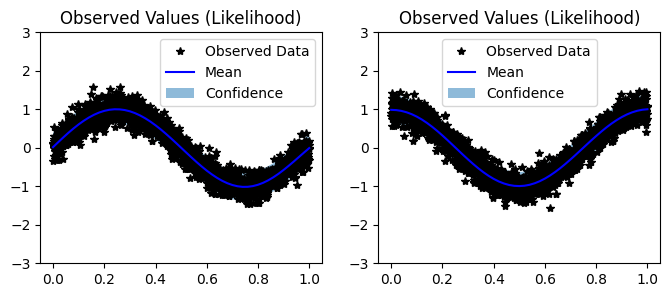

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1, 51)
test_i_task1 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=0)
test_i_task2 = torch.full((test_x.shape[0],1), dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_y1 = likelihood(model(test_x, test_i_task1))
    observed_pred_y2 = likelihood(model(test_x, test_i_task2))

# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')